In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score)

In [15]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [16]:
missing_data = dataset.isna().sum().sort_values()
missing_data

RID                            0
Gender                         0
Ageatscreening                 0
Diagnosis                      0
HipsSumAveragebaseline         1
MMSE0m                         3
ERCsASMbaseline                4
HipsSumVariancebaseline        7
HipsVariancebaseline           8
ERCsEntropybaseline            9
ERCsSumAveragebaseline        11
ERCsSumVariancebaseline       13
ERCsVariancebaseline          14
HipsContrastbaseline          14
ERCsVolumebaseline            14
ERCsContrastbaseline          18
HipsClusterShadebaseline      18
HipposcampusVolumebaseline    19
HipsCorelationbaseline        20
HipsEntropybaseline           23
HipsASMbaseline               25
ERCsCorelationbaseline        28
ERCsClusterShadebaseline      34
ERCs_thicknessbaseline        37
dtype: int64

In [17]:
# Step 1: split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((425, 23), (183, 23), (425,), (183,))

In [18]:
# Step 2: fill data temp using mean from training set
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_test.mean())

# Step 3: normalize features
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train_filled)
X_test_s = scaler.transform(X_test_filled)

In [19]:
tf.random.set_seed(42)

def run_denoising_autoencoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    noisy_inputs = layers.GaussianNoise(0.1)(inputs)
    
    # Encoder
    encoded = layers.Dense(126, activation="elu")(noisy_inputs)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(63, activation="elu")(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    
    # Decoder
    decoded = layers.Dense(126, activation="elu")(encoded)
    decoded = layers.Dense(63, activation="elu")(decoded)
    decoded = layers.Dense(input_dim, activation="linear")(decoded)
    
    # Autoencoder model
    autoencoder = models.Model(inputs, decoded)     
    return autoencoder

# Build and compile
input_dim = X_train_s.shape[1]
autoencoder = run_denoising_autoencoder(input_dim)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 23)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 126)            │         3,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 63)             │         8,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 126)            │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 63)             │         8,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 23)             │         1,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,562 (111.57 KB)

 Trainable params: 28,562 (111.57 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = autoencoder.fit(X_train_s,
                          X_train_s,
                          epochs=50,
                          batch_size=64,
                          validation_split=0.2,
                          verbose=2,
)

Epoch 1/50
6/6 - 6s - 1s/step - loss: 0.2782 - val_loss: 0.0846
Epoch 2/50
6/6 - 0s - 19ms/step - loss: 0.0970 - val_loss: 0.0595
Epoch 3/50
6/6 - 0s - 25ms/step - loss: 0.0767 - val_loss: 0.0419
Epoch 4/50
6/6 - 0s - 22ms/step - loss: 0.0594 - val_loss: 0.0338
Epoch 5/50
6/6 - 0s - 21ms/step - loss: 0.0491 - val_loss: 0.0278
Epoch 6/50
6/6 - 0s - 18ms/step - loss: 0.0419 - val_loss: 0.0237
Epoch 7/50
6/6 - 0s - 29ms/step - loss: 0.0370 - val_loss: 0.0200
Epoch 8/50
6/6 - 0s - 22ms/step - loss: 0.0321 - val_loss: 0.0178
Epoch 9/50
6/6 - 0s - 29ms/step - loss: 0.0295 - val_loss: 0.0162
Epoch 10/50
6/6 - 0s - 28ms/step - loss: 0.0281 - val_loss: 0.0154
Epoch 11/50
6/6 - 0s - 28ms/step - loss: 0.0273 - val_loss: 0.0144
Epoch 12/50
6/6 - 0s - 31ms/step - loss: 0.0255 - val_loss: 0.0135
Epoch 13/50
6/6 - 0s - 25ms/step - loss: 0.0243 - val_loss: 0.0130
Epoch 14/50
6/6 - 0s - 54ms/step - loss: 0.0232 - val_loss: 0.0125
Epoch 15/50
6/6 - 0s - 26ms/step - loss: 0.0223 - val_loss: 0.0119
Epoch 

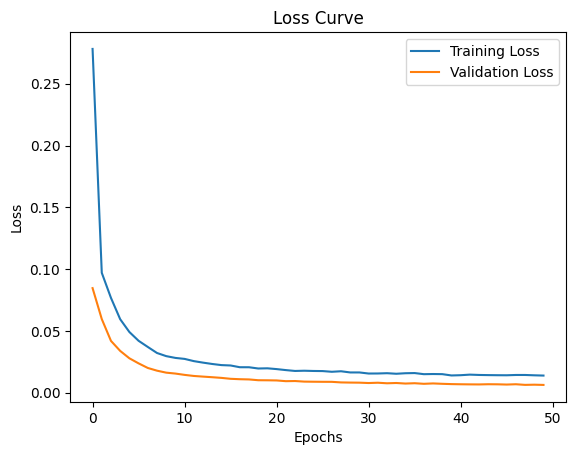

In [21]:
# Plot both training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
X_train_imputed = autoencoder.predict(X_train_s)
X_test_imputed = autoencoder.predict(X_test_s)

X_train_imputed_descaled = scaler.inverse_transform(X_train_imputed)
X_test_imputed_descaled = scaler.inverse_transform(X_test_imputed)

X_train_d = pd.DataFrame(X_train_imputed_descaled, columns=X_train_copy.columns)
X_test_d = pd.DataFrame(X_test_imputed_descaled, columns=X_test_copy.columns)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### Visualize

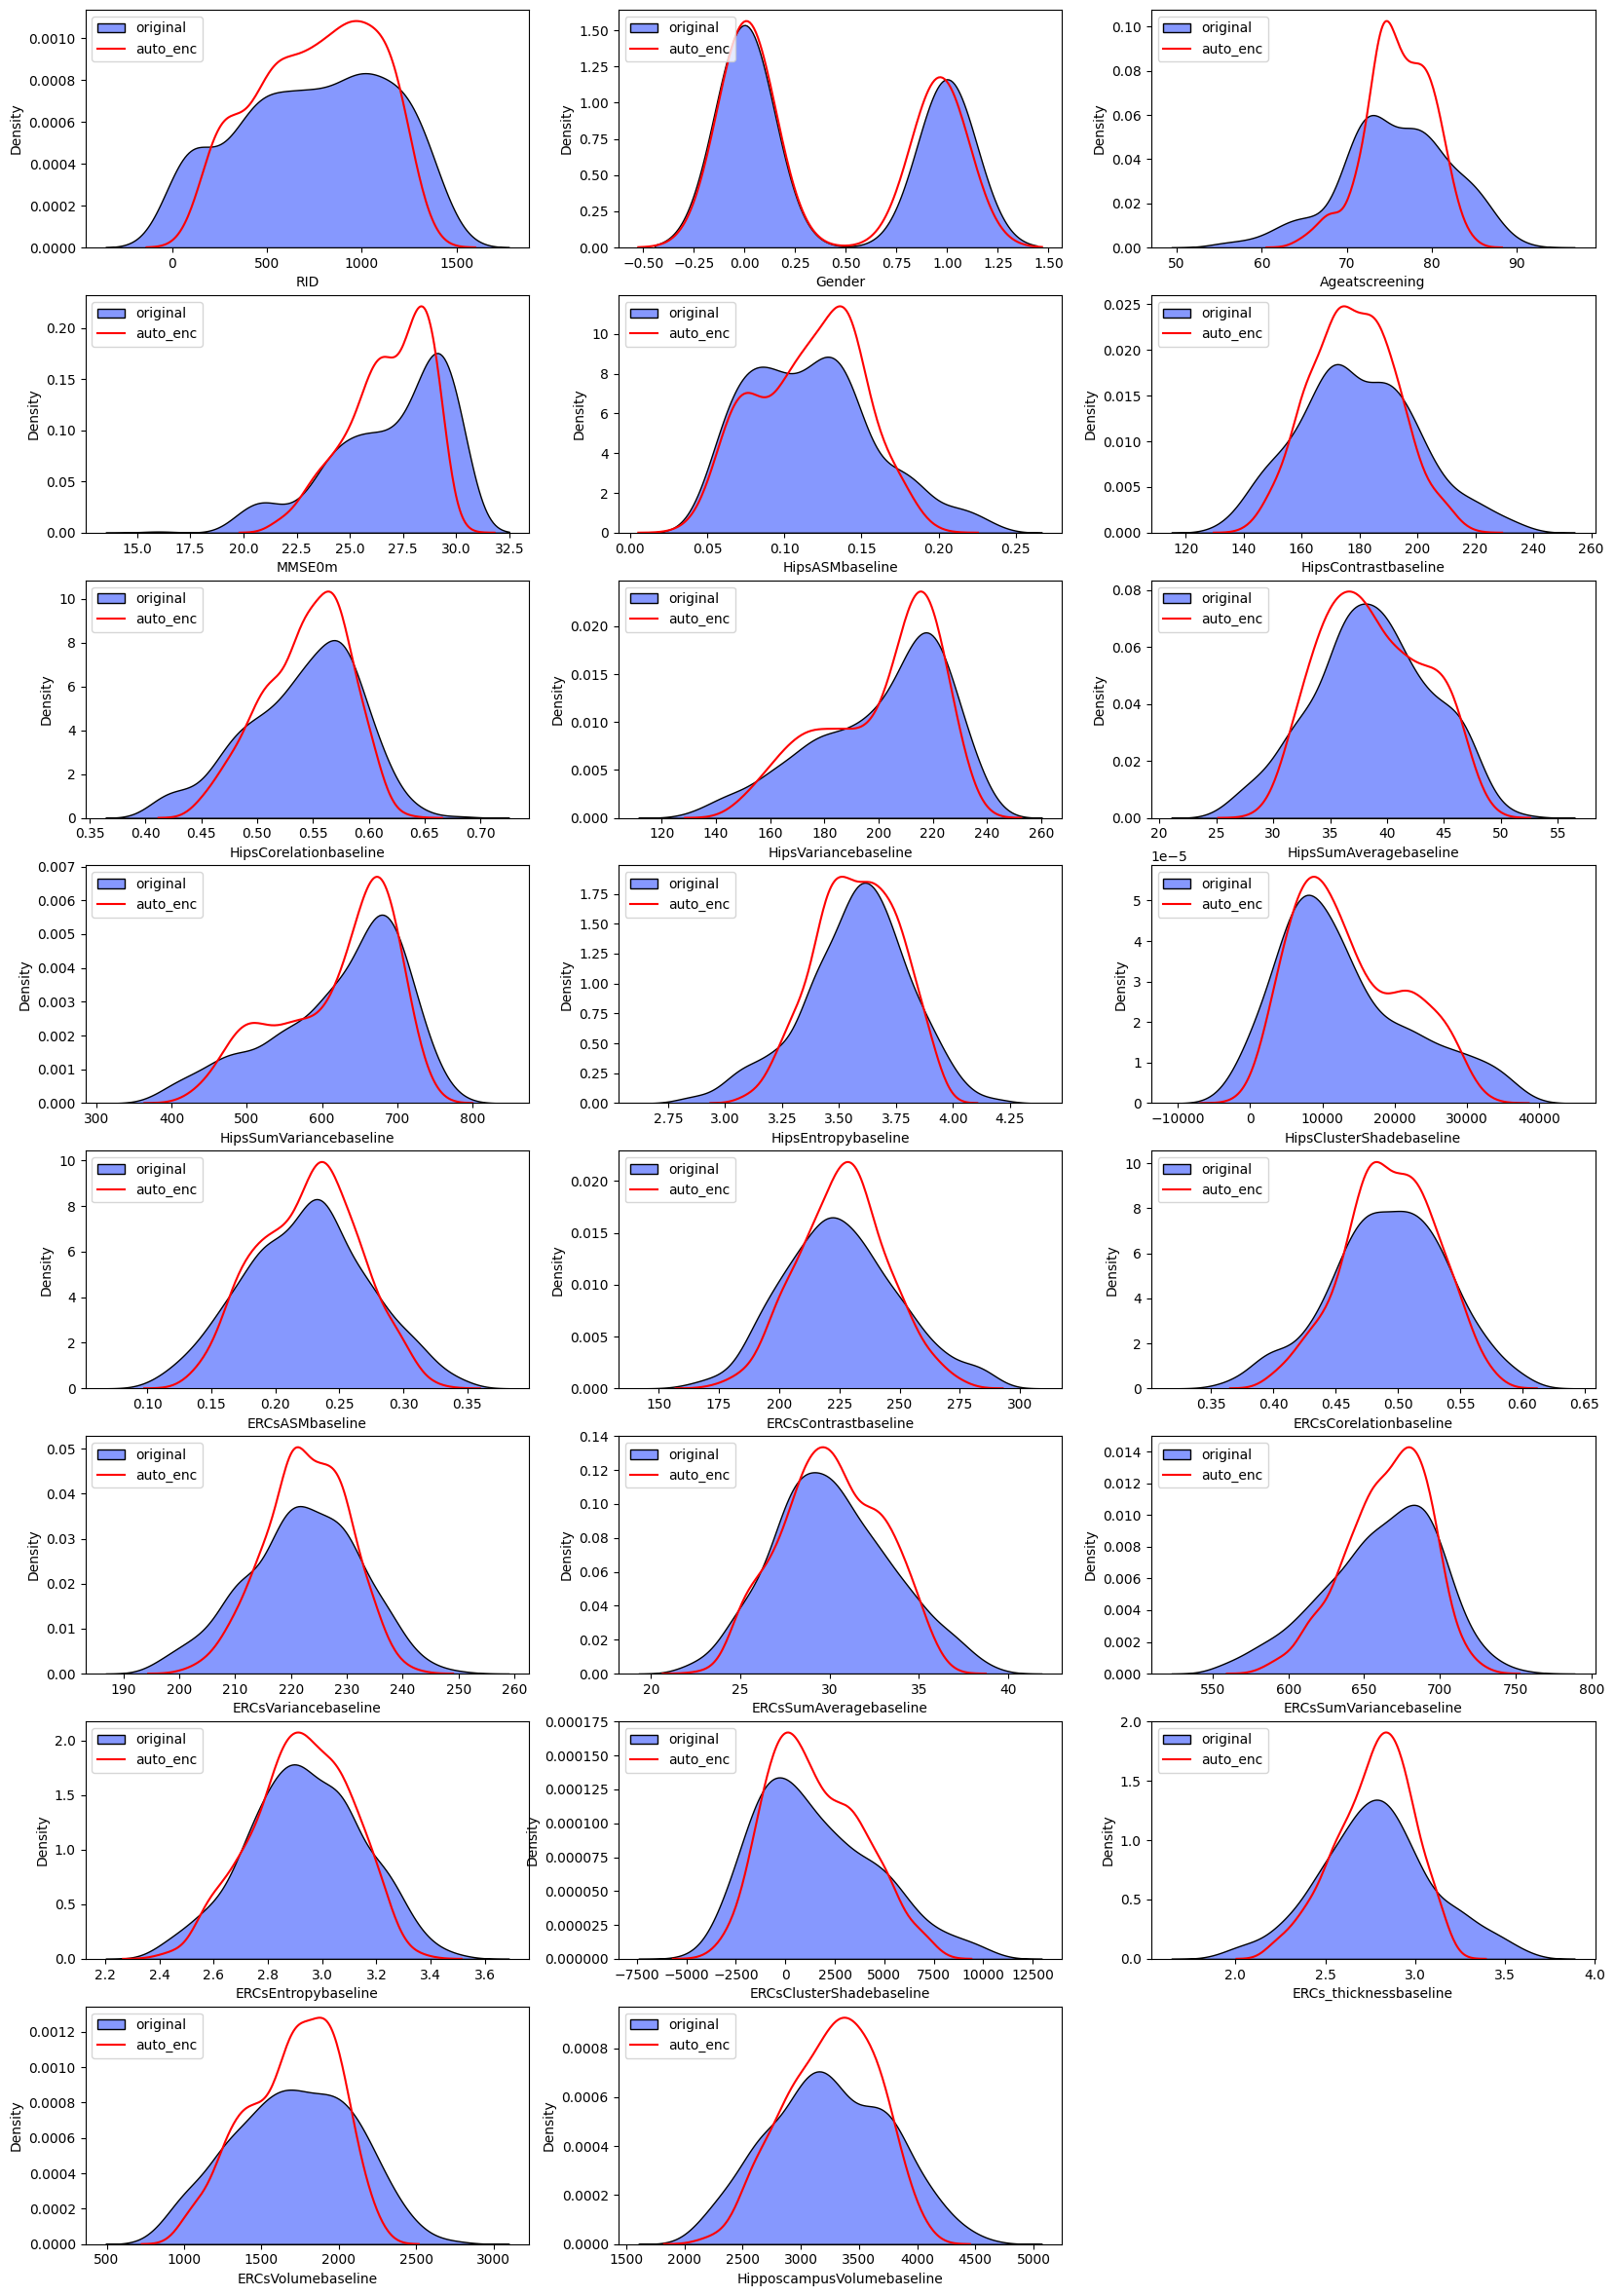

In [23]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_copy[X_train_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_d[X_train_d.columns[i]], color= "red")
    
    labels = ['original', 'auto_enc']
    plt.legend(labels, loc='upper left')

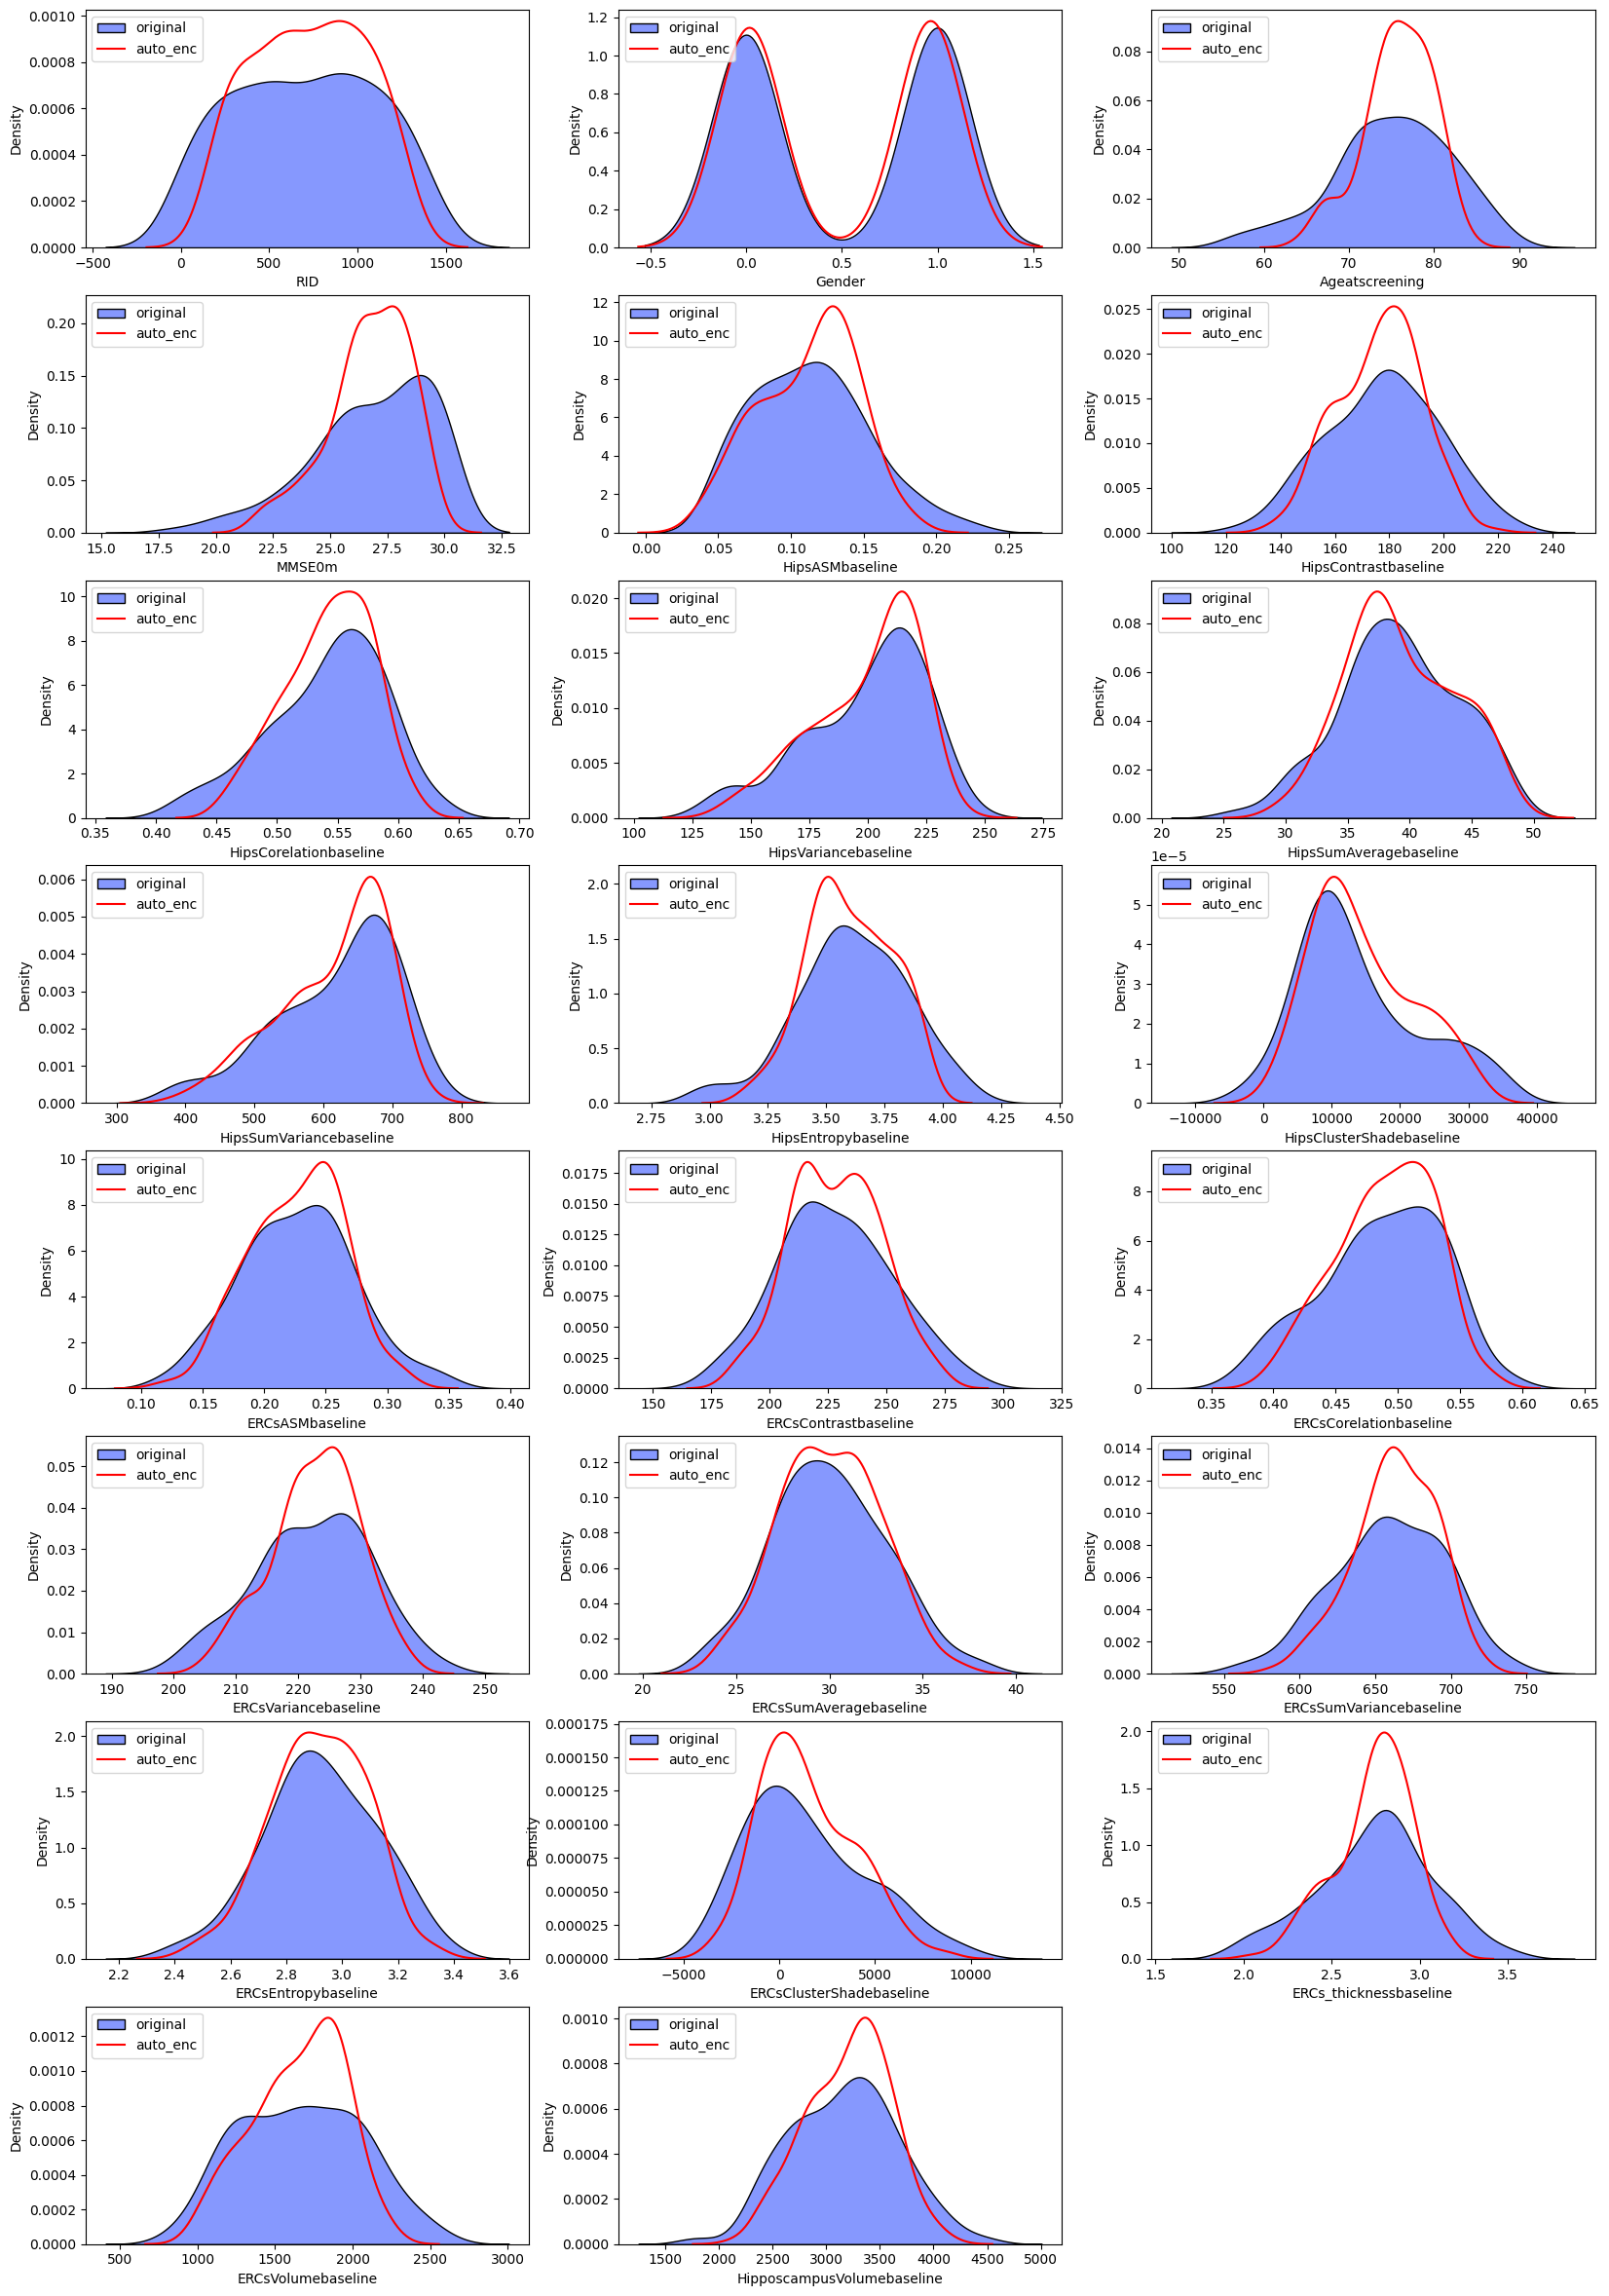

In [24]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_copy[X_test_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_d[X_test_d.columns[i]], color= "red")
    
    labels = ['original', 'auto_enc']
    plt.legend(labels, loc='upper left')

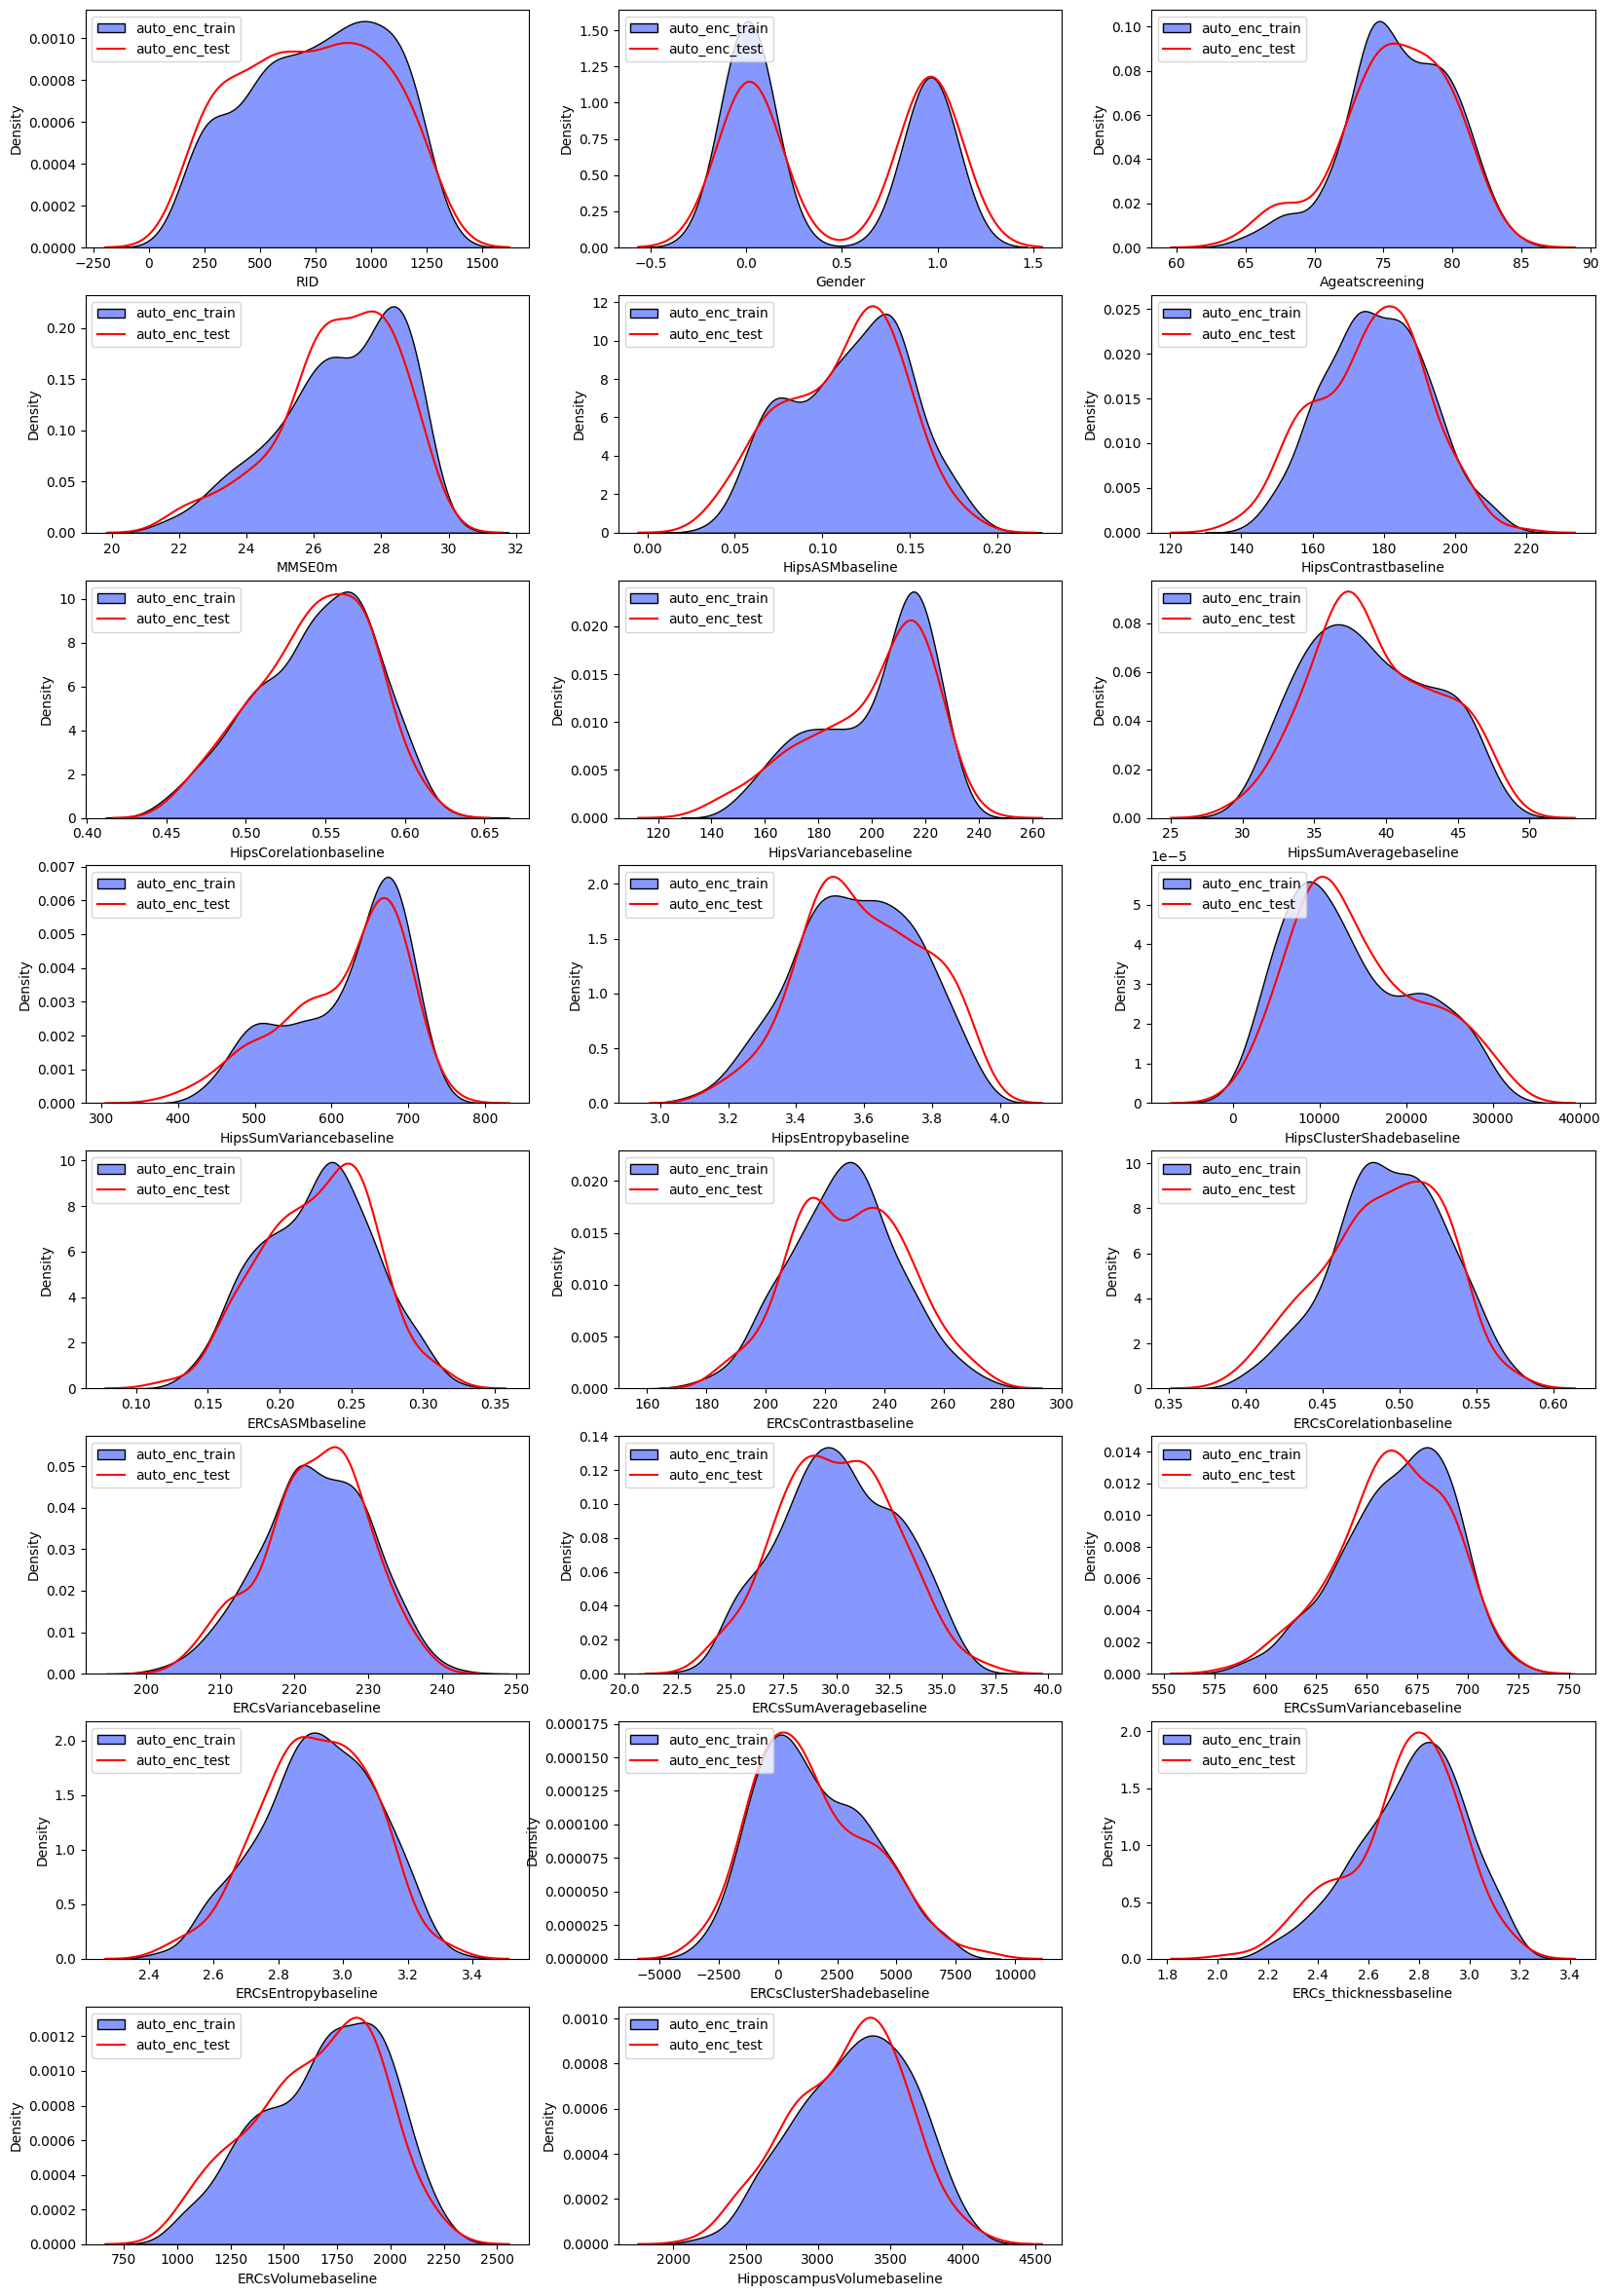

In [25]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_d[X_train_d.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_d[X_test_d.columns[i]], color= "red")
    
    labels = ['auto_enc_train', 'auto_enc_test']
    plt.legend(labels, loc='upper left')

### Validation Section

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

def run_random_forest(X_train, X_test, y_train, y_test):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        kf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(rf,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring=["accuracy", "roc_auc_ovr_weighted"],
                                           return_train_score=True,
        )
        
        # Print mean and std of each metric (for train and test)
        print("Stratified Cross Validation Results")
        print(f'Mean train accuracy:', np.mean(cross_val_results['train_accuracy']), '±', np.std(cross_val_results['train_accuracy']))
        print(f'Mean train ROC-AUC:', np.mean(cross_val_results['train_roc_auc_ovr_weighted']), '±', np.std(cross_val_results['train_roc_auc_ovr_weighted']))
        print(f'Mean test accuracy:', np.mean(cross_val_results['test_accuracy']), '±', np.std(cross_val_results['test_accuracy']))
        print(f'Mean test ROC-AUC:', np.mean(cross_val_results['test_roc_auc_ovr_weighted']), '±', np.std(cross_val_results['test_roc_auc_ovr_weighted']))
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Get predicted probabilities for ROC AUC
        pred_train_proba = rf.predict_proba(X_train)
        pred_test_proba = rf.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train_norm = rf.predict(X_train)
        pred_test_norm = rf.predict(X_test)
        
        # Calculate ROC-AUC
        roc_score_train = roc_auc_score(y_train, 
                                        pred_train_proba, 
                                        average="weighted", 
                                        multi_class="ovr",
        )
        roc_score_test = roc_auc_score(y_test,
                                    pred_test_proba,  
                                    average="weighted", 
                                    multi_class="ovr",
        )
        
        # Calculate accuracies
        accuracy_train = accuracy_score(y_train, pred_train_norm)
        accuracy_test = accuracy_score(y_test, pred_test_norm)
        
        # Print results
        print("\nFinal Predictions")
        print(f"Train Accuracy: {accuracy_train}")
        print(f"Train ROC-AUC: {roc_score_train}")
        print(f"Test Accuracy: {accuracy_test}")
        print(f"Test ROC-AUC: {roc_score_test}")


In [27]:
run_random_forest(X_train_d, X_test_d, y_train, y_test)

Stratified Cross Validation Results
Mean train accuracy: 0.8664705882352941 ± 0.008843115516689957
Mean train ROC-AUC: 0.9811418610000077 ± 0.002529583511980623
Mean test accuracy: 0.6141176470588234 ± 0.03894810672293375
Mean test ROC-AUC: 0.8288233321909271 ± 0.024102487167033247

Final Predictions
Train Accuracy: 0.8235294117647058
Train ROC-AUC: 0.9714132405409652
Test Accuracy: 0.5300546448087432
Test ROC-AUC: 0.7778918513797526
